In [1]:
%%capture
!pip install pyspark_dist_explore
!pip install chart-studio
!pip install -q kaggle

In [2]:
# Work With Files
from google.cloud import storage
import os

# Useful libraries:
from time import time
import numpy as np
import pandas as pd
import math

# To Plot:
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go

# Pyspark Lib:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf

from pyspark_dist_explore import hist

# Preprocess:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler

# Pysparl ML:
from pyspark.ml.regression import LinearRegression

In [3]:
PATH_BUCKET = 'gs://nyc_comp_bk/'
PATH_DATA = '/home/ubuntu/NYC_Taxi/data/'

In [4]:
os.chdir('/home/ubuntu/NYC_Taxi/')

In [5]:
class Work_On_Bucket():
    
    def __init__(self, bucket_name):
        # Get access to the bucket:
        storage_client = storage.Client()
        self.bucket = storage_client.get_bucket(bucket_name)
        
    def get_file_from_bucket(self, file_name, save_path):
        # Download the file:
        blob = self.bucket.blob(file_name)
        blob.download_to_filename(''.join([save_path, file_name]))
            
    def upload_file_to_bucket(self, file_name, folder_path):
        # Upload the File
        object_to_save = self.bucket.blob(file_name)
        object_to_save.upload_from_filename(folder_path + file_name)


### Get the Dataset:

In [6]:
Bucket = Work_On_Bucket('nyc_comp_bk')

In [7]:
# Set kaggle:
! mkdir ~/.kaggle
Bucket.get_file_from_bucket('kaggle.json', '/home/ubuntu/NYC_Taxi/')
! cp /home/ubuntu/NYC_Taxi/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download The Dataset
!kaggle competitions download -c new-york-city-taxi-fare-prediction

# Unzip the Files
! unzip new-york-city-taxi-fare-prediction.zip -d /home/ubuntu/NYC_Taxi/data/
! rm new-york-city-taxi-fare-prediction.zip

# Upload databses to bucket:
print('Start Uploding!')
Bucket.upload_file_to_bucket('train.csv', PATH_DATA)
Bucket.upload_file_to_bucket('test.csv', PATH_DATA)
print('Succesfully Uploaded!')

  4%|█▋                                     | 68.0M/1.56G [00:00<00:12, 126MB/s]

### Preliminary Steps (Load + Checks):

In [8]:
# Load Data:
train = spark.read.load(PATH_BUCKET+"train.csv", format="csv", inferSchema="true", header="true")
test = spark.read.load(PATH_BUCKET+"test.csv", format="csv", inferSchema="true", header="true")

# Load Test (Because pyspark changes the timestamp):
Bucket.get_file_from_bucket('test.csv', '')
original_test = pd.read_csv('test.csv')

In [9]:
# Get DB shape:
ncol = len(train.columns)
nrow = train.count()
print("The shape of the dataset is {:d} rows by {:d} columns".format(nrow, ncol))

The shape of the dataset is 55423856 rows by 8 columns


In [10]:
# Get the schema:
train.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [11]:
# Show some basic Statistics:
stats = train.select(train.columns[1:]).describe()
stats.toPandas()

,summary,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,count,55423856,55423856,55423856,55423856,55423480,55423480,55423856
1,mean,11.345045601663855,None,-72.50968444358728,39.91979178688818,-72.5112097297181,39.92068144482884,1.6853799201556816
2,stddev,20.7108321982325,None,12.848883381402654,9.642353041994934,12.782196517830771,9.633345796415126,1.327664357095968
3,min,-300.0,2009-01-01 00:00:27 UTC,-3442.059565,-3492.263768,-3442.024565,-3547.886698,0
4,max,93963.36,2015-06-30 23:59:54 UTC,3457.625683,3408.789565,3457.62235,3537.132528,208


In [12]:
# Check Nulls:
for c in train.columns[2:]:
    nans = train.where(col(c).isNull()).count()
    print('{:s}: {:d}'.format(c, nans))

pickup_datetime: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 376
dropoff_latitude: 376
passenger_count: 0


In [13]:
# Remove Rows with Missing Values:
train = train.na.drop(how='any')

In [14]:
# Check Duplicates:
print('The Duplicates are: {:d}'.format(train.count()-train.distinct().count()))

The Duplicates are: 1650


In [15]:
# Remove Duplicates:
train = train.distinct()

### Work With the Fare Price (Dependent Variale):

Checking the statistics, it is clear that some values are not possible, I am going to remove negatives values and all values that are lower that 2.50 dollars (https://nymag.com/nymetro/urban/features/taxi/n_20286/). Hence, I will keep all values greather than 2.50 dollars. By taking into account the max value, it is clear that some outlayers are present, nobady would want to spend 93,963 dollars for a trip. Working with the quantiles it is clear that there is somenthing wrong with the fare amount, the median is 999.9 dollars. As starting point let's remove what I am pretty sure that is an outlayer, namely everything over the fourth quntile, which represents all values greater than 93963.36 dollars. Computing again the quantiles now the fourth quantile is 999.99 dollars, Checking the other variables associated with these high fare amounts, it comes up that some of them doesn't make any sense: no changes in lat and long pick up and drop off, too small journey with one or two people for a so high price, missing values for lat and long and so on. I am going to keep al observations with fear amount less than 999.99 dollars, hopping that with the EDA I can clean more the data.

In [16]:
# Get statistics:
train.select('fare_amount').describe().toPandas()

,summary,fare_amount
0,count,55421830
1,mean,11.345105672079598
2,stddev,20.71113115840589
3,min,-300.0
4,max,93963.36


In [17]:
# Remove Values lower than 2.50$:
train = train.filter('fare_amount > 2.50')

In [18]:
# Compute Quantiles:
train.approxQuantile('fare_amount', [0.25, 0.50, 0.75, 0.975], 0.25)

[2.51, 358.21, 93963.36, 93963.36]

In [19]:
# Remove Outlayers:
train = train.filter('fare_amount < 93963.36')

In [20]:
# Compute Again Quantiles
train.approxQuantile('fare_amount', [0.25, 0.50, 0.75, 0.975], 0.25)

[2.51, 337.25, 75747.02, 75747.02]

In [21]:
# Remove other Outlayers:
train = train.filter('fare_amount < 999.99')

In [22]:
# Check Quantiles:
train.approxQuantile('fare_amount', [0.25, 0.50, 0.75, 0.975], 0.25)

[2.51, 300.0, 978.0, 978.0]

### Create My Base Line:

As Base Line I am going to use a Multiple Linear Regression that takes as input all the scaled (mean=0, sd=1) numerical variables.
As result I get an RMSE = 9.40719 on the Test.

In [23]:
NUMERICAL = ['pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'passenger_count']
TARGET = 'fare_amount'

In [24]:
# Get the feature Vector:
assembler = VectorAssembler(inputCols=NUMERICAL, outputCol="features")
train_df = assembler.transform(train)
train_df = train_df.select('features', TARGET)

In [25]:
# Scale Data:
scaler = StandardScaler(inputCol="features", outputCol="ScaledFeatures")
scalerModel = scaler.fit(train_df)
train_df = scalerModel.transform(train_df)
train_df = train_df.select('ScaledFeatures', TARGET)

In [26]:
# Run the Linear Regression:
lr = LinearRegression(featuresCol="ScaledFeatures", labelCol=TARGET, maxIter=10)
lr_model = lr.fit(train_df)

# Print Stats:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("MAE: {:.3f}".format(training_result.meanAbsoluteError))
print("R2: {:.3f}".format(training_result.r2))
print("***** Training Set *****")

***** Training Set *****
RMSE: 9.792
MAE: 6.030
R2: 0.000
***** Training Set *****


In [27]:
# Prepare the test:
test_df = assembler.transform(test.select(NUMERICAL))
test_df = test_df.select('features')
test_df = scalerModel.transform(test_df)

# Make Predictions:
predictions = lr_model.transform(test_df).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()

# Prepare the Submission:
submission = pd.concat([original_test['key'], predictions['fare_amount']], axis=1)
submission.to_csv('submission.csv', index=False)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "First Submission"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

fileName        date                 description       status    publicScore  privateScore  
--------------  -------------------  ----------------  --------  -----------  ------------  
submission.csv  2021-06-26 11:42:04  First Submission  complete  9.40719      9.40719       
submission.csv  2021-06-23 15:15:57  First Submission  complete  9.40712      9.40712       
submission.csv  2021-06-23 15:10:56  First Submission  complete  9.40712      9.40712       
submission.csv  2021-06-23 14:58:58  None              error     None         None          
submission.csv  2021-06-23 14:58:06  First Submission  error     None         None          
submission.csv  2021-06-23 14:55:46  None              error     None         None          
submission.csv  2021-06-23 14:54:33  First Submission  error     None         None          
submission.csv  2021-06-23 14:52:36  None              error     None         None          
submission.csv  2021-06-23 14:51:55  First Submission  error     None 

### EDA

#### 1) Latitude and Longitude

From the study of the quantiles it is clear that is plenty of outlayers, because the NYC coordinates are (lat=40.730610 lon=-73.935242). Even working with quantiles, removing anything out of the I and III quartile things don't change so much. Therefore, I opt for anothe option, I draw a triangle around the area of interest, a triangle because NY City is on an icleand which reminds a triangle, but the area is bigger than the iceland, to take into acocunt possible trips from the countriside. Then I remove all observations for which the pick up position or drop off position outside the area.
To decide whether a point is in the triangle I walk clockwise or counterclockwise around the triangle and project the point onto the segment I am crossing by using the dot product. Finally, check that the vector created is on the same side for each of the triangle's segments.

The it is possible to compute new features that can be useful both for the model and to remove more outlayers, namely the Absolute Distance, the Haversinee Distance and the Minkowski Distance (that for p=1 is the Manhattan and for p=2 is the Euclidean distance). All the distances are expressed in kilometers. To obtain some of them I need to know to how much km corresponds the variation of 1 degree for each coordinates and it turns put that for Latitude it is 111 Km and for Longitude is 85 Km. Checking the statistics of th emetrics it is clear that there are many outlayers. To drop them I am going to use a kind of voting, for each observation I get the mean of manhattan, euclidean and haversine distances metrics and remove the observation if its distance mean is less than 0.5 (namel less than 500m trip).

Another feature that can improve my model is the direction (in degree) of the trip. Because the computed distancem is only an approximation and o the angle can improve this approximation. To comput the distance I use the Bearing Algorithm and I multiply the result by -1 because of the negative longitude.

Exploiting the function to compute the haversian distance (which is the more realistic) I compute the distanes from the airports, both for pick up and drop off and I create a column that says whether the pick up or dorp off happened near by the airport. It is possible that there the costs are higher or maybe fixed. It is possible to check using a groupby that the average price is far away higher than the one for a standard trip. Furthermore, for rhe most of them the standard deviation shows that maybe the prices are not fixed or anyway that the prices can change up to +/-30$ for the most volatile airport (EWR).

Then I suppose that a there must be a relationship between fear amount and length of the trip (it maybe also connected with duration). Hence, I create a variable tha distinguish among trips under the mean and over the mean. It seems that my hypothesis is confirmed.

In [28]:
# Check I, II and III Quantiles:
np.array([train.approxQuantile('pickup_longitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('pickup_latitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('dropoff_longitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('dropoff_latitude', [0.25, 0.50, 0.75], 0.25)])

array([[-3442.059565,  2417.441523,  3457.625683],
       [-3492.263768,  1853.9362  ,  3408.789565],
       [-3442.024565,    40.891532,  3457.62235 ],
       [-3547.886698,   405.3     ,  3537.132528]])

In [29]:
# Write function to check if a point is a triangle:

def point_in_triangle(lat, long):
    """
    phuclv (https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle)
    Returns True if the point is inside the triangle
    and returns False if it falls outside.
    - The argument *point* is a tuple with two elements
    containing the X,Y coordinates respectively.
    - The argument *triangle* is a tuple with three elements each
    element consisting of a tuple of X,Y coordinates.
    """
    # Unpack arguments
    x = lat
    y = long
    ax, ay = (39.74274655286439, -75.26399018397262)
    bx, by = (41.58840050439113, -75.18708588709761)
    cx, cy = (41.07279488244855, -71.76484467616011)
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)

def is_in_area(lat1, lon1, lat2, lon2):
    
    pick = point_in_triangle(lat1, lon1)
    drop = point_in_triangle(lat2, lon2)
    
    return all([pick, drop])

is_in_area_udf = F.udf(is_in_area, BooleanType())

In [30]:
# Remove any point outside the given area:
train = train.withColumn('keep', is_in_area_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ) )
train = train.filter("keep == True")
train = train.drop('keep')

In [31]:
train.select(col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude')).describe().show()

+-------+-------------------+------------------+-------------------+-------------------+
|summary|    pickup_latitude|  pickup_longitude|   dropoff_latitude|  dropoff_longitude|
+-------+-------------------+------------------+-------------------+-------------------+
|  count|           54035164|          54035164|           54035164|           54035164|
|   mean|  40.75086908812028|-73.97552681981169|  40.75126957781323| -73.97462208403955|
| stddev|0.02747470264987258|0.0355824322536576|0.03138283190684735|0.03545131465385524|
|    min|          39.804188|          -75.2463|           39.80016|         -75.243442|
|    max|          41.519495|          -72.0619|          41.567147|          -71.97642|
+-------+-------------------+------------------+-------------------+-------------------+



In [32]:
# Write Functions needed to Create Coordinates Features

class Coordinates_Transform():

    def __init__(self, df):

        self.df = df
        self.haversine_udf = F.udf(Coordinates_Transform.haversine_stat, DoubleType())
        self.direction_udf = F.udf(Coordinates_Transform.calculate_dir, DoubleType())
        self.airports_udf = F.udf(Coordinates_Transform.identify_airports, StringType())


    @staticmethod
    def haversine_stat(pick_lat, drop_lat, pick_long, drop_long):

        longit_a, latit_a, longit_b, latit_b = map(math.radians, [pick_long,  pick_lat, drop_long, drop_lat])
        dist_longit = longit_b - longit_a
        dist_latit = latit_b - latit_a
        # Calculate area
        area = math.sin(dist_latit/2)**2 + math.cos(latit_a) * math.cos(latit_b) * math.sin(dist_longit/2)**2
        # Calculate the central angle
        central_angle = 2 * math.asin(math.sqrt(area))
        RADIUS = 6371
        # Calculate Distance
        distance = central_angle * RADIUS
        return round(distance, 3)

    def add_dist_metrics(self):
       
        # Absolute Lat e Long Distance:
        self.df = self.df.withColumn( 'abs_dist_longitude', F.round( F.abs( col('pickup_longitude') - col('dropoff_longitude') ) * 85, 3 ) )
        self.df = self.df.withColumn( 'abs_dist_latitude', F.round( F.abs( col('pickup_latitude') - col('dropoff_latitude') ) * 111 , 3 ) )

        # Manhattan Distance:
        self.df = self.df.withColumn( 'manhattan_dist', F.round( col('abs_dist_longitude') + col('abs_dist_latitude'), 3 ) )

        # Euclidean Distance:
        self.df = self.df.withColumn( 'euclidean_dist',  F.round( F.sqrt( col('abs_dist_longitude')**2 + col('abs_dist_latitude')**2 ), 3 ) )

        # Haversine Distance:
        self.df = self.df.withColumn( 'haversine_dist', 
                                     self.haversine_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ) ) 

    return self.df

    @staticmethod
    def calculate_dir(lat1, lon1, lat2, lon2):

        '''
        https://www.movable-type.co.uk/scripts/latlong.html
        It is measured in 0 - 360 degrees
        '''

        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        theta = math.atan2(y, x)*180/math.pi

        return (-theta + 360) % 360



    def direction(self):
        self.df = self.df.withColumn('direction', self.direction_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ))
        return self.df

    def third_dim_remap(self):
        '''
        The credit for the next features goes to Jan van der Vegt @datascience.stackexchange.com
        https://datascience.stackexchange.com/users/14904/jan-van-der-vegt
        '''
        # Compute coordinates for pickup:
        self.df = self.df.withColumn('pickup_x', F.cos('pickup_latitude') * F.cos('pickup_longitude'))
        self.df = self.df.withColumn('pickup_y', F.cos('pickup_latitude') * F.sin('pickup_longitude'))
        self.df = self.df.withColumn('pickup_z', F.sin('pickup_latitude'))

        # Compute coordinates for dropoff
        self.df = self.df.withColumn('dropoff_x', F.cos('dropoff_latitude') * F.cos('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_y', F.cos('dropoff_latitude') * F.sin('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_z', F.sin('dropoff_latitude'))

        return self.df


    @staticmethod
    def identify_airports(pick_lat, drop_lat, pick_long, drop_long):

        # Set the coordinates of airports:
        JFK_LAT = 40.641766
        JFK_LON = -73.780968

        LGR_LAT = 40.773013
        LGR_LON = -73.870229

        EWR_LAT = 40.689531
        EWR_LON = -74.174462

        # Compute distances:
        pick_up_jfk = Coordinates_Transform.haversine_stat(JFK_LAT, pick_lat, JFK_LON, pick_long)
        drop_off_jfk = Coordinates_Transform.haversine_stat(drop_lat, JFK_LAT, drop_long, JFK_LON)

        pick_up_lgr = Coordinates_Transform.haversine_stat(LGR_LAT, pick_lat, LGR_LON, pick_long)
        drop_off_lgr = Coordinates_Transform.haversine_stat(drop_lat, LGR_LAT, drop_long, LGR_LON)

        pick_up_ewr = Coordinates_Transform.haversine_stat(EWR_LAT, pick_lat, EWR_LON, pick_long)
        drop_off_ewr = Coordinates_Transform.haversine_stat(drop_lat, EWR_LAT, drop_long, EWR_LON)

        print(pick_up_jfk, drop_off_jfk)
        # Assign a value:
        if pick_up_jfk < 1:
            return 'PICK_JFK'
        elif drop_off_jfk < 1:
            return 'DROP_JFK'
        if pick_up_lgr < 1:
            return 'PICK_LGR'
        elif drop_off_lgr < 1:
            return 'DROP_LGR'
        if pick_up_ewr < 1:
            return 'PICK_EWR'
        elif drop_off_ewr < 1:
            return 'DROP_EWR'
        else:
            return 'NO_AIRPORT'

    def airports(self):

        self.df = self.df.withColumn('airport', 
                                     self.airports_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ))
        return self.df

    def long_short_trip(self):

        quantiles = self.df.approxQuantile('haversine_dist', [0.5, 0.75], 0.25)
        med = quantiles[0]
        third = quantiles[1]
        self.df = self.df.withColumn( 'long_short', F.when(col('haversine_dist') <= med, 'SHORT') \
                                     .when( ( col('haversine_dist') > med ) & ( col('haversine_dist') < third ), 'LONG' ) \
                                    .otherwise('VERY_LONG') )
        return self.df



In [33]:
# Add Distance metrics:
coordTransform = Coordinates_Transform(train)
train = coordTransform.add_dist_metrics()

In [34]:
# Let's Check df:
train.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,54035164,54035164,54035164,54035164,54035164
1,mean,1.9342445804180306,2.364087192980479,4.298331773398526,3.3344409736222875,3.325451624464394
2,stddev,2.889671485794271,2.561164783985788,4.784266862461805,3.62235660624304,3.607759663695022
3,min,0.0,0.0,0.0,0.0,0.0
4,max,158.809,128.346,210.365,163.92,162.283


In [35]:
# Let's remove outlayers:
DIST_METRICS = ['manhattan_dist', 'euclidean_dist', 'haversine_dist']
n = len(DIST_METRICS)
row_mean  = (sum(col(x) for x in DIST_METRICS) / n).alias("mean_dist")
train = train.where( (row_mean >= 0.5) )

In [36]:
train.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,52251796,52251796,52251796,52251796,52251796
1,mean,1.9961398628288216,2.440378376926985,4.436518239755822,3.4414884706546713,3.4322147401593694
2,stddev,2.9186445590757844,2.5702910072982506,4.805222891448259,3.6360757676570565,3.6212921089502137
3,min,0.0,0.0,0.5,0.44,0.438
4,max,158.809,128.346,210.365,163.92,162.283


In [37]:
# Add Directions:
train = coordTransform.direction()

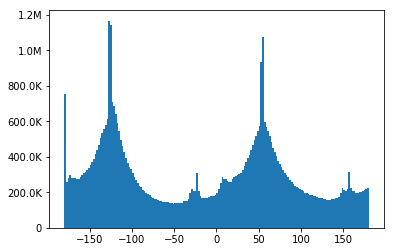

In [38]:
fig, ax = plt.subplots()
hist(ax, train.select('direction'), bins = 180)
plt.show()

In [ ]:
# Let's Add when starting point or arrival is at the airport:
train = coordTransform.airports()

In [ ]:
# Check avg price for the airports:
train.select('airport','fare_amount').groupBy('airport').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).sort('avg(fare_amount)').show()

+----------+------------------+------------------------+------------------+
|   airport|  avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+------------------+------------------------+------------------+
|NO_AIRPORT| 9.905956647934762|       6.806858795221454|          51241803|
|  PICK_LGR|30.629194763162026|      11.131674923824347|           1020234|
|  DROP_LGR| 31.31190311077054|       7.433062935377362|            617757|
|  PICK_JFK| 44.71171522788871|      15.359248835348657|            766009|
|  DROP_JFK|50.423755266641486|       8.108452610737064|            321125|
|  PICK_EWR|  70.6121127116502|       29.83637300815114|              3957|
|  DROP_EWR| 70.93169044322414|      13.843744196655729|             64279|
+----------+------------------+------------------------+------------------+



In [ ]:
# Add a binning for the length, based on the haversine distance:
train = coordTransform.long_short_trip()

In [ ]:
# Check avg price for binned trip length:
train.select('long_short' ,'fare_amount').groupBy('long_short').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).show()

+----------+-----------------+------------------------+------------------+
|long_short| avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+-----------------+------------------------+------------------+
|     SHORT|7.547497339124412|       4.484496814775224|          37341092|
|      LONG|19.86574124815227|      12.402911437837933|          16694072|
+----------+-----------------+------------------------+------------------+

